In [150]:
import numpy as np
from scipy.integrate import solve_ivp

import sympy as sp
from sympy.physics.mechanics import dynamicsymbols, init_vprinting

# matplotlib imports
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation

from qbstyles import mpl_style


mpl_style(dark=True)
init_vprinting()

<img src="two_body_sketch.jpg" alt="Two Body Sketch" width=300>

Newton's law of gravitation states that the gravitational force between two bodies is proportional to the product of their masses and inversely proportional to the square of the distance between them. Using vector calculus, we can write this as:

$$
\frac{d^2\vec{r}_i}{dt^2} = \sum_{j \neq i} \frac{G m_j}{\left| \vec{r}_{ij}\right|^3}\vec{r}_{ij}
$$

where $\vec{r}_i$ and $m_i$ are the position and mass of the $i \text{th}$ body, respectively. $\vec{r}_{ij} = \vec{r}_j - \vec{r}_i$ is the vector pointing from the $i \text{th}$ body to the $j \text{th}$ body. The gravitational constant $G$ is a universal constant that is the same for all bodies.

One problem is that the dimensions are gross, with the gravitational constant $G = 6.674 \times 10^{-11}$ being too small to efficiently compute. So we will non-dimensionalize our quantities and get an equation like this:

$$
\frac{d^2\vec{r'}_i}{dt'^2} = \sum_{j \neq i} \frac{m_j'}{\left| \vec{r'}_{ij}\right|^3}\vec{r'}_{ij}
$$

where:
* $\vec{r'}_i = \vec{r}_i / L$ where $L$ is some characteristic length in the system
* $m'_i = m_i / M$ where $M$ is some characteristic mass in the system
* $t' = t \sqrt{G M / L^3}$ where M and L are the characteristic mass and length

For the rest of this, we will drop the prime notation and assume that we are working with the non-dimensionalized quantities. After we solve our ODEs in terms of the dimensionless $t'$, we can convert back to the dimensional $t$ by using:

$$
t = t' \sqrt{\frac{L^3}{G M}}
$$

The two-body problem I will be considering is the Alpha Centauri AB system. While Alpha Centauri is a triple star system, the third star Proxima Centauri is much less massive than the other two so we will just consider the binary star system and the force of gravity on it. Therefore, we will set our characteristic quantities:

* $L = 3.441 \times 10^{12} \text{ m}$ (distance between Alpha Centauri A and B)
* $M = 1.989 \times 10^{30} \text{ kg}$ (mass of Sun)

Now we may simulate the motion of the Alpha Centauri AB system. Alpha Centauri A will be mass 1 and B will be mass 2.

In [151]:
param_G = 6.67408e-11 # gravitational constant
param_M = 1.989e30 # mass of the sun
param_L = 1.496e11 # 1 AU
param_time = 79.762 * 365.25 * 24 * 3600 # Period of Alpha Centauri AB
param_v = 2 * np.pi * param_L / param_time # orbital velocity of Alpha Centauri AB

param_m1 = 1.1 # mass of body 1
param_m2 = 0.9 # mass of body 2

x1_0 = -0.5 # initial x position of body 1
y1_0 = 0.0 # initial y position of body 1
z1_0 = 0.0 # initial z position of body 1

x2_0 = 0.5 # initial x position of body 2
y2_0 = 0.0 # initial y position of body 2
z2_0 = 0.0 # initial z position of body 2

vx1_0 = 0.01 # initial x velocity of body 1
vy1_0 = 0.01 # initial y velocity of body 1
vz1_0 = 0.0 # initial z velocity of body 1

vx2_0 = -0.05 # initial x velocity of body 2
vy2_0 = 0.0 # initial y velocity of body 2
vz2_0 = -0.1 # initial z velocity of body 2

Any second-order ordinary differential equation,

$$
\ddot{y} = f(y, \dot{y}, t)
$$

may be expressed as coupled first-order ODEs by introducing a new variable $v = \dot{y}$:

$$
\dot{y} = v_{y} \\
\dot{v}_{y} = f(y, v_{y}, t)
$$

Now we may define the state vector $\vec{S}$ containing everything we want to solve for:

$$
\vec{S} = \langle x_1, y_1, z_1, x_2, y_2, z_2, v_{x_1}, v_{y_1}, v_{z_1}, v_{x_2}, v_{y_2}, v_{z_2} \rangle
$$

We will need to define a function that takes in the state vector and returns the derivative of the state vector. This function will be passed into the ODE solver.

In [152]:
def S_dot(t, S, m1, m2):
    x1, y1, z1, x2, y2, z2, vx1, vy1, vz1, vx2, vy2, vz2 = S
    r = np.sqrt((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2)
    return [
        vx1,
        vy1,
        vz1,
        vx2,
        vy2,
        vz2,
        m2/r**3 * (x2 - x1),
        m2/r**3 * (y2 - y1),
        m2/r**3 * (z2 - z1),
        m1/r**3 * (x1 - x2),
        m1/r**3 * (y1 - y2),
        m1/r**3 * (z1 - z2)
    ]

Now we may solve our system of ODEs

In [153]:
S_0 = [x1_0, y1_0, z1_0, x2_0, y2_0, z2_0, vx1_0, vy1_0, vz1_0, vx2_0, vy2_0, vz2_0]

t_0 = 0.0 # initial time
t_f = 20.0 # final time
time_frame = [t_0, t_f]
t_eval = np.linspace(t_0, t_f, 10000)

sol = solve_ivp(
    S_dot,
    time_frame,
    S_0,
    args=(param_m1, param_m2),
    t_eval=t_eval,
)

In [154]:
x1_array, y1_array, z1_array, x2_array, y2_array, z2_array, vx1_array, vy1_array, vz1_array, vx2_array, vy2_array, vz2_array = sol.y
time = sol.t

In [162]:
plt.plot(x1_array)

In [155]:
np.savetxt(
    "two_body_problem.csv",
    np.transpose([time, x1_array, x2_array, y1_array, y2_array, z1_array, z2_array, vx1_array, vx2_array, vy1_array, vy2_array, vz1_array, vz2_array]),
    delimiter=",", 
    header="time,x1,x2,y1,y2,z1,z2,vx1,vx2,vy1,vy2,vz1,vz2",
)

We must note that we have our solutions in their dimensionless form. To convert back to dimensional form, we must use the equations we had set out prior.

In [156]:
# Convert time to seconds
scale_factor = 1/np.sqrt(param_G * param_M / param_L**3)

time *= scale_factor

In [160]:
# To make the animation take less time, get every 10th point

ani_x1_array = x1_array[::5]
ani_y1_array = y1_array[::5]
ani_z1_array = z1_array[::5]
ani_x2_array = x2_array[::5]
ani_y2_array = y2_array[::5]
ani_z2_array = z2_array[::5]

ani_time = time[::5]

C:\Users\Owner\AppData\Local\Temp\ipykernel_6224\3016501945.py:18: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 11
C:\Users\Owner\AppData\Local\Temp\ipykernel_6224\3016501945.py:28: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.set_pane_color((12/255, 28/255, 35/255, 1.0))
C:\Users\Owner\AppData\Local\Temp\ipykernel_6224\3016501945.py:29: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.set_pane_color((12/255, 28/255, 35/255, 1.0))
C:\Users\Owner\AppData\Local\Temp\ipykernel_6224\3016501945.py:30: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.set_pane_color((12/255, 28/255, 35/255, 1.0))
C:\Users\Owner\A

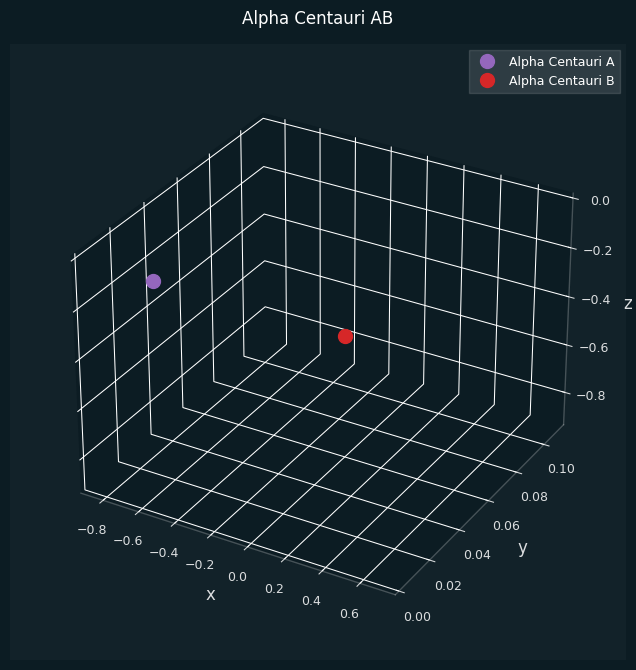

In [161]:
# Animation
def animate(i):
    point1.set_data(ani_x1_array[i], ani_y1_array[i])
    point1.set_3d_properties(ani_z1_array[i])

    point2.set_data(ani_x2_array[i], ani_y2_array[i])
    point2.set_3d_properties(ani_z2_array[i])
    
    line1.set_data(ani_x1_array[:i], ani_y1_array[:i])
    line1.set_3d_properties(ani_z1_array[:i])
    
    line2.set_data(ani_x2_array[:i], ani_y2_array[:i])
    line2.set_3d_properties(ani_z2_array[:i])

fig = plt.figure(figsize=(8, 8))
fig.delaxes(fig.axes[0])
ax = fig.add_subplot(111, projection='3d')
ax.dist = 11

point1, = ax.plot([], [], [], 'o', color='tab:purple', markersize=10, label='Alpha Centauri A')
point2, = ax.plot([], [], [], 'o', color='tab:red', markersize=10, label='Alpha Centauri B')

line1, = ax.plot([], [], [], color='tab:purple', linewidth=1)
line2, = ax.plot([], [], [], color='tab:red', linewidth=1)


# Make the background panes # 0C1C23
ax.w_xaxis.set_pane_color((12/255, 28/255, 35/255, 1.0))
ax.w_yaxis.set_pane_color((12/255, 28/255, 35/255, 1.0))
ax.w_zaxis.set_pane_color((12/255, 28/255, 35/255, 1.0))

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.set_xlim(1.5 * np.min(np.concatenate((x1_array, x2_array))), 1.5 * np.max(np.concatenate((x1_array, x2_array))))
ax.set_ylim(1.5 * np.min(np.concatenate((y1_array, y2_array))), 1.5 * np.max(np.concatenate((y1_array, y2_array))))
ax.set_zlim(1.5 * np.min(np.concatenate((z1_array, z2_array))), 1.5 * np.max(np.concatenate((z1_array, z2_array))))
    
ax.legend(loc='upper right')
ax.set_title('Alpha Centauri AB')


ani = animation.FuncAnimation(fig, animate, frames=len(ani_time), interval=1, blit=False, repeat=False)
ani.save('Animations/two_body_problem.gif', writer='pillow', fps=30)

C:\Users\Owner\AppData\Local\Temp\ipykernel_6224\3856134341.py:6: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 11


IndexError: index 750 is out of bounds for axis 0 with size 678

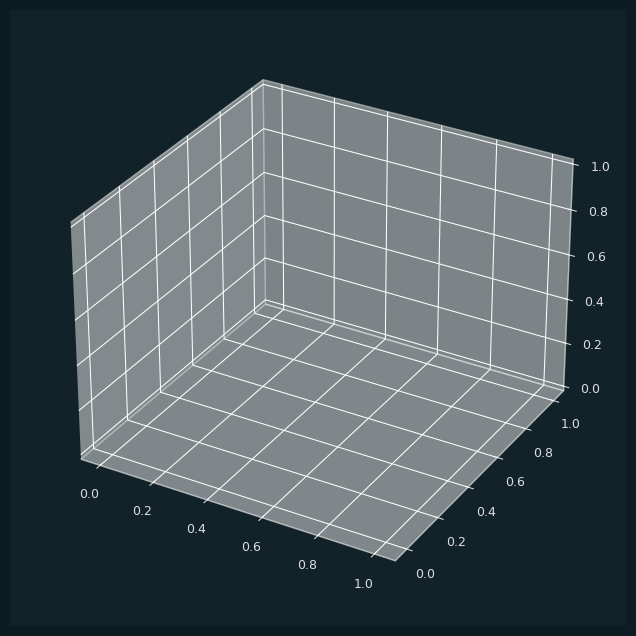

In [159]:
n = 750

fig = plt.figure(figsize=(8, 8))
fig.delaxes(fig.axes[0])
ax = fig.add_subplot(111, projection='3d')
ax.dist = 11

point1, = ax.plot([], [], 'o', color='tab:purple', markersize=10, label='Alpha Centauri A')
point2, = ax.plot([], [], [], 'o', color='tab:red', markersize=10, label='Alpha Centauri B')

point1.set_data(ani_x1_array[n], ani_y1_array[n])
point1.set_3d_properties(ani_z1_array[n])

point2.set_data(ani_x2_array[n], ani_y2_array[n])
point2.set_3d_properties(ani_z2_array[n])

# change face colour 3d to 0C1C23
ax.w_xaxis.set_pane_color((12/255, 28/255, 35/255, 1.0))
ax.w_yaxis.set_pane_color((12/255, 28/255, 35/255, 1.0))
ax.w_zaxis.set_pane_color((12/255, 28/255, 35/255, 1.0))

plt.legend(loc='upper right')

ax.set_xlim(1.5 * np.min(np.concatenate((x1_array, x2_array))), 1.5 * np.max(np.concatenate((x1_array, x2_array))))
ax.set_ylim(1.5 * np.min(np.concatenate((y1_array, y2_array))), 1.5 * np.max(np.concatenate((y1_array, y2_array))))
ax.set_zlim(1.5 * np.min(np.concatenate((z1_array, z2_array))), 1.5 * np.max(np.concatenate((z1_array, z2_array))))